In [6]:
import sys
sys.path.append('../')

import numpy as np
np.random.seed(314159)
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import parameter_tuning
import plot_boundary
import analysis_functions as af

from metric_functions import compute_accuracy, compute_auc_from_scores
from kernel_SVM_functions import rbf_kernel
from classifiers import QUBOSoftMarginClassifier, SoftMarginKernelClassifier

main_dir = '..'

In [7]:
"""Want to conduct analysis on synth_0.2, synth_0.3, synth_0.4"""
filename = 'synth_0.2.csv'

data = np.loadtxt(f'{main_dir}/synth_data/{filename}', delimiter = ',')

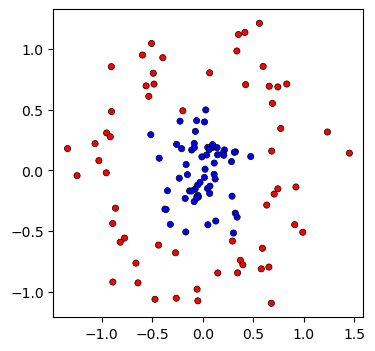

In [8]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.scatter(data[:, 0], data[:, 1], c = data[:, 2], cmap = 'bwr', s = 20, edgecolors = 'black', linewidths = 0.5)
plt.show()

In [9]:
train_size = 0.2

X = data[:, :-1]
t = data[:, -1]

X_train, X_test, t_train, t_test = train_test_split(X, t, train_size = train_size, shuffle = True, stratify = t)

t_train = t_train.reshape(-1, 1)
t_test = t_test.reshape(-1, 1)

## Parameter calibration for QUBOSVM

In [10]:
B_values = [2, 3, 5, 10]
K_values = [2, 3, 4]
R_values = [0, 1, 3, 5]
gamma_values = [2 ** i for i in range(-3, 3)]
kernel_func = rbf_kernel

run = False

if run:

    accuracy_results, auroc_results, times = parameter_tuning.tune_qsvm_parameters(X_train, t_train, B_values, K_values, R_values, gamma_values, kernel_func, num_models = 30)

    np.save(f'{main_dir}/results/QUBO-{filename}-accuracy', accuracy_results)
    np.save(f'{main_dir}/results/QUBO-{filename}-auroc', auroc_results)
    np.save(f'{main_dir}/results/QUBO-{filename}-time', times)


Progress: 100%|██████████| 288/288 [13:30<00:00,  2.82s/it]


## Parameter calibration for cSVM

In [11]:
C_values = [2 ** i for i in range(0, 7)]
gamma_values = [2 **i for i in range(-3, 3)]
kernel_func = rbf_kernel

run = False

if run:

    accuracy_results, auroc_results, times = parameter_tuning.tune_csvm_parameters(X_train, t_train, C_values, gamma_values, kernel_func)

    np.save(f'{main_dir}/results/kSVM-{filename}-accuracy', accuracy_results)
    np.save(f'{main_dir}/results/kSVM-{filename}-auroc', auroc_results)
    np.save(f'{main_dir}/results/kSVM-{filename}-time', times)


## Load file data

In [12]:
qSVM_accuracy = np.load(f'{main_dir}/results/QUBO-{filename}-accuracy.npy')
qSVM_auroc = np.load(f'{main_dir}/results/QUBO-{filename}-auroc.npy')

cSVM_accuracy = np.load(f'{main_dir}/results/kSVM-{filename}-accuracy.npy')
cSVM_auroc = np.load(f'{main_dir}/results/kSVM-{filename}-auroc.npy')

In [13]:
qSVM_accuracy.shape, cSVM_accuracy.shape

((4, 3, 4, 6), (7, 6))

## Best performance

In [14]:
print(f'cSVM best accuracy {np.max(cSVM_accuracy[:, 1: ])} \n cSVM best auroc {np.max(cSVM_auroc[:, 1: ])} \n')
print(f'qSVM best accuracy {np.max(qSVM_accuracy)} \n qSVM best auroc {np.max(qSVM_auroc)} \n')

cSVM best accuracy 0.95 
 cSVM best auroc 1.0 

qSVM best accuracy 0.8950000000000001 
 qSVM best auroc 1.0 



In [15]:
C_values, gamma_values

([1, 2, 4, 8, 16, 32, 64], [0.125, 0.25, 0.5, 1, 2, 4])

In [16]:
list(zip(*np.where(cSVM_auroc == 1)))

[(0, 5),
 (1, 3),
 (3, 5),
 (4, 4),
 (4, 5),
 (5, 3),
 (5, 4),
 (5, 5),
 (6, 2),
 (6, 3),
 (6, 4),
 (6, 5)]

## Top 20 QUBO models

In [17]:
val_list = [B_values, K_values, R_values, gamma_values]
model_indices = af.find_best(qSVM_auroc, 20)
top_models = [af.get_params(val_list, model_indices[i]) for i in range(len(model_indices))]

In [18]:
tp_acc_mean = []
tp_acc_std = []

tp_auc_mean = []
tp_auc_std = []

kernel_func = rbf_kernel
n = 50

#Averaging the accuracy and auc for each parameter set over 50 models
for i, model_parameters in enumerate(top_models):

    accuracy = []
    auroc = []

    for j in range(n):
        
        qsmc = QUBOSoftMarginClassifier(model_parameters[0], model_parameters[1], model_parameters[2], kernel_func, model_parameters[3])
        qsmc = qsmc.make_QUBO_problem(X_train, t_train).fit(X_train, t_train)
        scores = qsmc.decision_function(X_test)
        preds = qsmc.predict(X_test)
        
        accuracy.append(compute_accuracy(preds, t_test))
        auroc.append(compute_auc_from_scores(scores, t_test))

    tp_acc_mean.append(np.mean(accuracy))
    tp_acc_std.append(np.std(accuracy))

    tp_auc_mean.append(np.mean(auroc))
    tp_auc_std.append(np.std(auroc))

In [19]:
tp_auc_mean

[0.9810243055555558,
 0.9803993055555555,
 0.978515625,
 0.9836979166666667,
 0.9778125,
 0.9767361111111111,
 0.9831076388888889,
 0.9845833333333333,
 0.9759809027777777,
 0.9740104166666668,
 0.9792708333333333,
 0.9773871527777779,
 0.9818142361111112,
 0.9868142361111112,
 0.9676475694444444,
 0.9795833333333333,
 0.9810677083333332,
 0.9873524305555555,
 0.9819010416666667,
 0.9854340277777777]

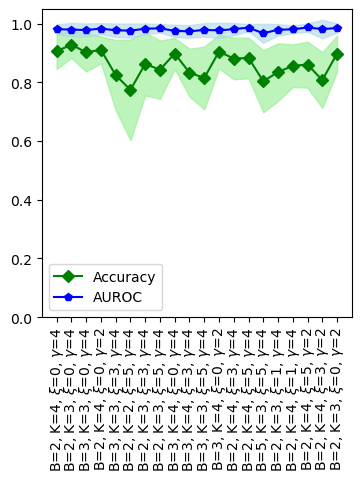

In [20]:
fig, ax = plt.subplots(figsize = (4, 4))

af.plot_top_models(top_models, np.array([tp_acc_mean, tp_acc_std]), np.array([tp_auc_mean, tp_auc_std]), fig = fig, ax = ax)
plt.show()

## Boundary plots

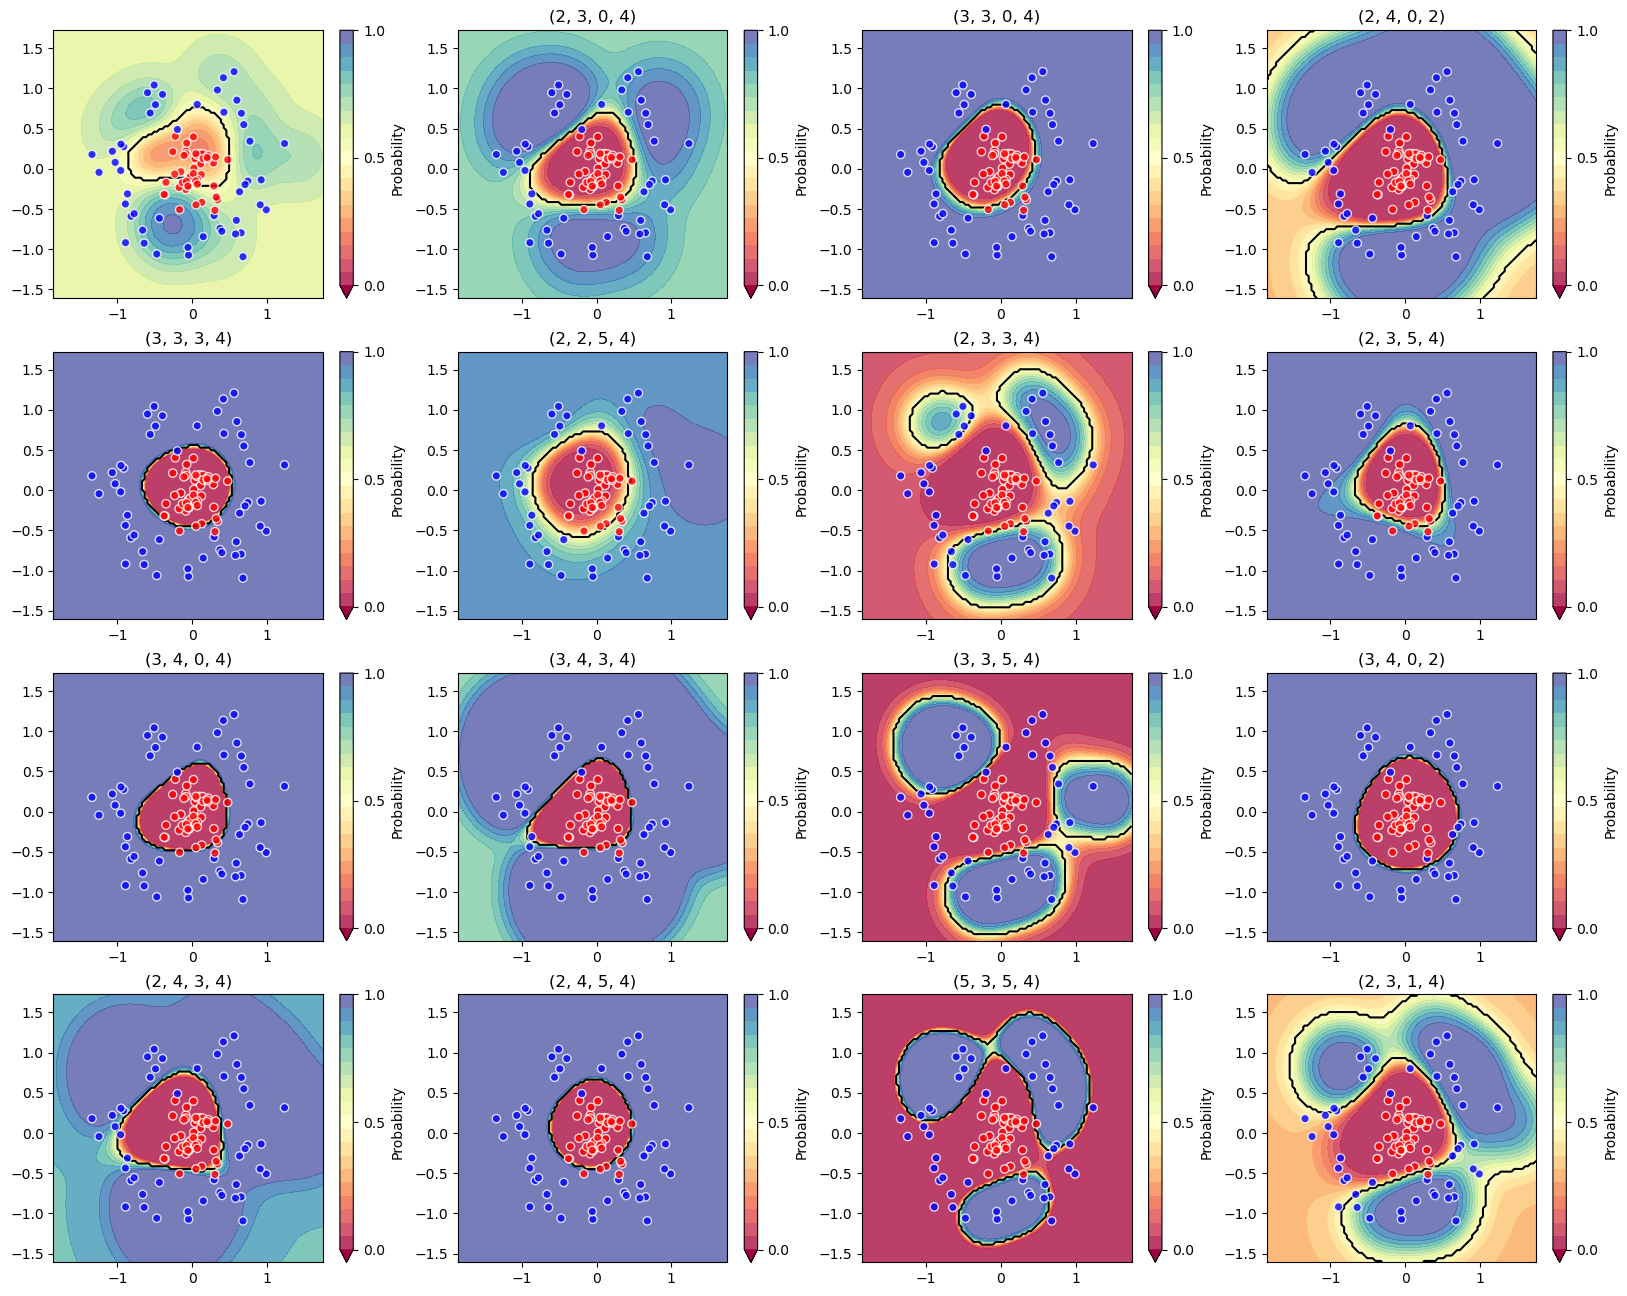

In [21]:
fig, ax = plt.subplots(4, 4, figsize = (20, 16))

csvm = SoftMarginKernelClassifier(3, kernel_func, 6)
csvm = csvm.fit(X_train, t_train)
plot_boundary.plot(X_test, t_test, csvm, contour_func = 'predict_proba', colorbar = True, fig = fig, ax = ax[0, 0])

for i in range(4):
    for j in range(4):
        if i + j == 0:
            continue
        else:
            index = 4 * i + j
            B = top_models[index][0]
            K = top_models[index][1]
            R = top_models[index][2]
            gamma = top_models[index][3]
            
            clf = QUBOSoftMarginClassifier(B, K, R, kernel_func, gamma)
            clf = clf.make_QUBO_problem(X_train, t_train).fit(X_train, t_train)
            plot_boundary.plot(X_test, t_test, clf, contour_func = 'predict_proba', colorbar = True, fig = fig, ax = ax[i, j])

            ax[i, j].set_title(f'({B}, {K}, {R}, {gamma})')
    
plt.show()

## Variance Analysis

In [22]:
"""QUBO SVM variance of hyper parameters"""

qSVM_variances = {'B': {}, 'K': {}, 'R': {}, 'gamma': {}}

for i, key in enumerate(list(qSVM_variances.keys())):
    auc = np.var(qSVM_auroc, axis = i)
    acc = np.var(qSVM_accuracy, axis = i)
    qSVM_variances[key]['auc'] = (np.mean(auc), np.var(auc))
    qSVM_variances[key]['acc'] = (np.mean(acc), np.var(acc))